In [53]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

#### 1. Проанализируем данные о покупках в интернет-магазине. Определение покупателей, которым можно выдать карту лояльности.

##### 1.1.Загрузим часть датасета в переменную `shop_df`: колонки `tc` и `art_sp`. <br> <br> Переименуем колонки, придав им осмысленные названия.

**Описание сабдатасета:**
- **tc** - ID покупателя;
- **art_sp** - название бренда.

In [55]:
shop_df = pd.read_csv('materials/lesson_3_data.csv', 
                      encoding='windows-1251', 
                      usecols=['tc', 'art_sp'])
shop_df.head()

,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


In [56]:
shop_df = shop_df.rename(columns={'tc': 'user_id', 'art_sp': 'brand_info'}).query('user_id >= 0')
shop_df.head()

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


##### 1.2.Разделим информацию из колонки `brand_info`. Выделим название бренда.  

In [57]:
# Вариант с регулярными выражениями.
import re

shop_df['brand_name'] = shop_df.brand_info.apply(lambda x: re.findall(r'\w*brand\w*', x.lower())[0])
shop_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,store_brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,store_brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,brand_2


In [58]:
# Вариант с применением метода split.
shop_df['brand_name'] = shop_df.brand_info.apply(lambda x: x.split(' ')[-1])
shop_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


##### 1.3.Определим суммарное количество каждого из покупателей. Отберём покупателей, число покупок которых больше медианного значения.

In [64]:
users_purchases = shop_df.groupby('user_id', as_index=False)\
    .agg({'brand_name': 'count'})\
    .rename(columns={'brand_name': 'purchases'})\

median_purchases = users_purchases.purchases.median()

users_purchases_selection = users_purchases.query('purchases >= @median_purchases')

users_purchases_selection.head()

,user_id,purchases
0,1031,6
1,4241,5
2,17311,2
3,17312,2
4,19972,3


##### 1.4.Определим для каждого из пользователя количество его уникальных покупок (брендов). Отберём покупателей, число покупок которых больше медианного значения.

In [65]:
users_unique_brands = shop_df.groupby('user_id', as_index=False)\
    .agg({'brand_name': pd.Series.nunique})\
    .rename(columns={'brand_name': 'unique_brands'})

users_unique_brands.head()

,user_id,unique_brands
0,1031,2
1,4241,2
2,17311,1
3,17312,2
4,19972,2


##### 1.5.Определим для каждого из пользователя количество покупок  его любимого бренда.

In [66]:
lovely_brand_purchases_df = shop_df.groupby(['user_id', 'brand_name'], as_index=False)\
    .agg({'brand_info':'count'})\
    .sort_values(['user_id','brand_info'], ascending=[False, False])\
    .groupby('user_id')\
    .head(1)\
    .rename(columns={'brand_name': 'lovely_brand','brand_info': 'lovely_brand_purchases'})

lovely_brand_purchases_df.head()

,user_id,lovely_brand,lovely_brand_purchases
18186,1408849249,Store_Brand,1
18185,1408840919,Store_Brand,1
18184,1408832719,Brand_4,3
18183,1408825059,Brand_1,1
18182,1408817589,Store_Brand,2


##### 1.6.Объединим полученные данные о покупках пользователей.

In [67]:
loyalty_df = users_purchases\
    .merge(users_unique_brands, on='user_id')\
    .merge(lovely_brand_purchases_df, on='user_id')

loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,17311,2,1,Brand_4,2
3,17312,2,2,Brand_1,1
4,19972,3,2,Brand_4,2


##### 1.7.Определим количество лояльных пользователей. Под лояльными пользователями в данном случае будем понимать пользователей, совершавших покупки товаров только одного бренда.

In [70]:
loyal_users = loyalty_df[loyalty_df.unique_brands == 1]

loyal_users.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases
2,17311,2,1,Brand_4,2
7,24341,4,1,Store_Brand,4
8,24342,1,1,Store_Brand,1
9,24722,4,1,Brand_4,4
11,27471,1,1,Brand_1,1


##### 1.8.Определим коэффициент лояльности пользователей. Визуализировать распределение пользователей по коэффициенту лояльности.

In [71]:
loyalty_df['loyalty_score'] = loyalty_df.lovely_brand_purchases / loyalty_df.purchases

loyalty_df.head()

,user_id,purchases,unique_brands,lovely_brand,lovely_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,17311,2,1,Brand_4,2,1.000000
3,17312,2,2,Brand_1,1,0.500000
4,19972,3,2,Brand_4,2,0.666667


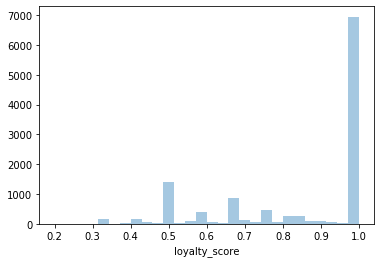

In [72]:
ax = sns.distplot(loyalty_df.loyalty_score, kde=False)

##### 1.9.Визуализировать данные о количестве лояльных покупателей каждого из брендов и распределение их коэффициентов лояльности.

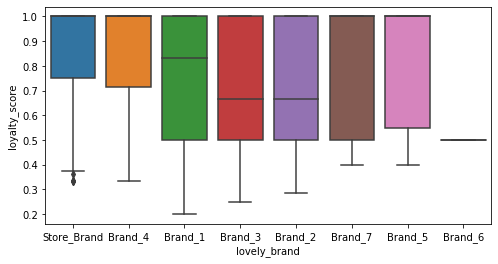

In [94]:
plt.figure(figsize=(8,4))

sns.boxplot(x='lovely_brand', y='loyalty_score', data=loyalty_df)

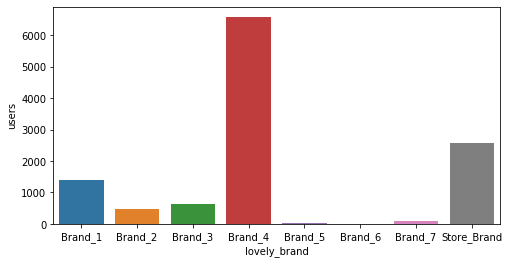

In [93]:
plt.figure(figsize=(8,4))

ax = sns.barplot(x="lovely_brand", 
                 y="users", 
                 data=loyalty_df.groupby('lovely_brand', as_index=False)\
                                .agg({'user_id': 'count'})\
                                .rename(columns={'user_id':'users'}))

#### 2.Вернёмся к данным о поездках на такси. На этот раз – из Перу, с рейтингами водителей, пассажиров, координатами, и парой других деталей!

##### 2.1.Загрузите датасет в переменную `peru_taxi_data`. Также укажите, что столбцы start_at, end_at, arrived_at должны быть переведены в формат datetime.
**Описание датасета**:
- **journey_id** – уникальный id поездки;
- **ser_id** – id пользователя;
- **driver_id** – id водителя;
- **taxi_id** – id машины;
- **icon** – тип поездки;
- **start_type** – тип заказа (asap, reserved, delayed);
- **start_at** – время начала поездки;
- **start_lat** – исходное местоположение пользователя, широта;
- **start_lon** – исходное местоположение пользователя, долгота;
- **end_at** – время окончания поездки;
- **end_lat** – итоговое местоположение, широта;
- **end_lon** – итоговое местоположение, долгота;
- **end_state** – состояние заказа;
- **driver_start_lat** – исходное местоположение водителя, широта;
- **driver_start_lon** – исходное местоположение водителя, долгота;
- **arrived_at** – время прибытия водителя;
- **source** – платформа, с которой сделан заказ;
- **driver_score** – оценка водителя клиентом;
- **rider_score** – оценка клиента водителем.

In [98]:
peru_taxi_URL = 'https://stepik.org/media/attachments/lesson/359240/taxi_peru.csv'

peru_taxi_data = pd.read_csv(peru_taxi_URL, 
                             sep=';',
                            parse_dates=['start_at','end_at','arrived_at'])

peru_taxi_data.head()

,journey_id,user_id,driver_id,taxi_id,icon,start_type,start_at,start_lat,start_lon,end_at,end_lat,end_lon,end_state,driver_start_lat,driver_start_lon,arrived_at,source,driver_score,rider_score
0,23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,b12f4f09c783e29fe0d0ea624530db56,executive,asap,2010-11-16 16:44:00,"-12,13983536","-77,02355957",2010-11-16 17:29:00,"-12,05537033","-77,0413208",drop off,"-12,10825481","-77,0272739",2010-11-16 17:02:00,iPhone,5.0,5.0
1,dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:34:00,"-12,13874817","-76,99536133",2010-06-01 00:37:00,"-12,12465668","-77,02886963",not found,NaN,NaN,NaT,iPhone,NaN,NaN
2,dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-05-31 05:01:00,"-12,12453079","-77,02780151",2010-05-31 05:04:00,"-12,13883209","-76,99530029",not found,NaN,NaN,NaT,iPhone,NaN,NaN
3,dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NaN,NaN,executive,asap,2010-06-01 00:29:00,"-12,13885117","-76,99530029",2010-06-01 00:32:00,"-12,12458801","-77,02896118",not found,NaN,NaN,NaT,iPhone,NaN,NaN
4,85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,0accdd3aa5a322f4129fa20b53278c69,executive,reserved,2010-09-11 23:55:00,"-12,08995438","-76,92626953",2010-09-12 01:07:00,"-12,02223206","-77,10638428",drop off,"-12,08311558","-76,9277072",2010-09-11 23:50:00,iPhone,4.0,5.0


In [47]:
peru_taxi_data.shape

(23111, 19)

In [48]:
peru_taxi_data.count()

journey_id          23111
user_id             23111
driver_id           19726
taxi_id             19726
icon                23111
start_type          23111
start_at            23111
start_lat           23111
start_lon           23111
end_at              22835
end_lat             23111
end_lon             23111
end_state           23099
driver_start_lat    19621
driver_start_lon    19621
arrived_at          17716
source              22988
driver_score         7650
rider_score         15390
dtype: int64

In [101]:
peru_taxi_data.dtypes

journey_id                  object
user_id                     object
driver_id                   object
taxi_id                     object
icon                        object
start_type                  object
start_at            datetime64[ns]
start_lat                   object
start_lon                   object
end_at              datetime64[ns]
end_lat                     object
end_lon                     object
end_state                   object
driver_start_lat            object
driver_start_lon            object
arrived_at          datetime64[ns]
source                      object
driver_score               float64
rider_score                float64
dtype: object

##### 2.2.Проверьте, с какой платформы было сделано больше всего заказов. В ответе укажите значение в `%`, округлённое до целого.

In [114]:
peru_taxi_data\
.source\
.value_counts(normalize=True)\
.apply(lambda x: int(x*100))\
.to_frame()\
.rename(columns={'source':'orders_percent'})\
.head(1)

,orders_percent
iPhone,42


##### 2.3.Проверим, как распределены оценки водителей (driver_score). Для подготовки данных выполните следующие шаги:

1. Посчитайте частоту встречаемости каждой из оценок;
1. Переведите в проценты и округлите до 2 знаков после запятой;
1. Сбросьте индексы;
1. Переименуйте колонки в driver_score и percentage;
1. Отсортируйте по driver_score в порядке возрастания (от 0 до 5);
1. Запишите результат в driver_score_counts.

In [123]:
driver_score_counts = peru_taxi_data\
.dropna(subset=['driver_score'])\
.driver_score\
.value_counts(normalize=True)\
.mul(100)\
.round(2)\
.reset_index()\
.rename(columns={'index':'score','driver_score':'percentage_of_driver_rating'})\
.sort_values('score')

driver_score_counts

,score,percentage_of_driver_rating
2,0.0,14.30
4,1.0,1.23
5,2.0,0.81
3,3.0,2.97
1,4.0,21.88
0,5.0,58.81


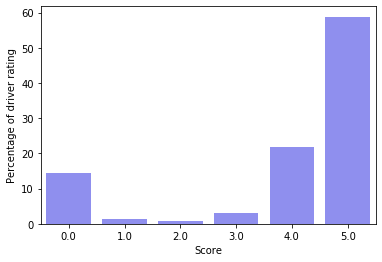

In [124]:
ax = sns.barplot(x='score', y='percentage_of_driver_rating', data=driver_score_counts, color='blue', alpha=0.5)
ax.set(xlabel='Score', ylabel='Percentage of driver rating')
# sns.despine()  # убрать часть рамки графика
plt.show()

##### 2.4.Проделайте аналогичные шаги для rider_score (оценок клиентов водителями). Постройте график. Сравните с распределением оценок водителей?

In [125]:
rider_score_counts = peru_taxi_data\
.dropna(subset=['rider_score'])\
.rider_score\
.value_counts(normalize=True)\
.mul(100)\
.round(2)\
.reset_index()\
.rename(columns={'index':'score','rider_score':'percentage_of_rider_rating'})\
.sort_values('score')

rider_score_counts

,score,percentage_of_rider_rating
2,0.0,2.29
4,1.0,0.21
5,2.0,0.19
3,3.0,1.38
1,4.0,8.83
0,5.0,87.10


In [129]:
scores_counts = driver_score_counts.merge(rider_score_counts, on='score').set_index('score')
scores_counts

,percentage_of_driver_rating,percentage_of_rider_rating
score,,
0.0,14.30,2.29
1.0,1.23,0.21
2.0,0.81,0.19
3.0,2.97,1.38
4.0,21.88,8.83
5.0,58.81,87.10


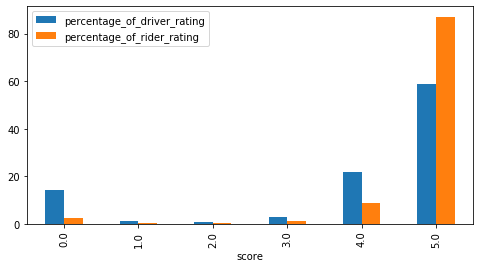

In [132]:
scores_counts.plot.bar(figsize=(8,4))